<a href="https://colab.research.google.com/github/bahgat-ahmed/Abstractive-Text-Summarization/blob/master/Detect%20Gender%20using%20Voice%20Attributes/Determine_Gender_using_Voice_Attributes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Helper Functions

Helper functions for Automating Selection and Making it Easier as explained near the end of the notebook.

In [118]:
def evaluate_model_fn(classifier, X_train, y_train, X_test, y_test):
    
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    ac = accuracy_score(y_test, y_pred)

    return ac

In [119]:
def choose_best_model_fn(X_train, y_train, X_test, y_test):
    """Get the best model based on its accuracy where the models'
    hyperparameters were tuned after feature selection that is based on the
    initial Exploratory Data Analysis (EDA).
    """

    model_accuracy_dict = defaultdict(int)

    # Logistic Regression
    lr = LogisticRegression(random_state=0)
    model_accuracy_dict['Logistic Regression'] = evaluate_model_fn(lr, X_train,
                                                    y_train, X_test, y_test)
    
    # Support Vector Machine
    svc = SVC(kernel='linear', random_state=0)
    model_accuracy_dict['Support Vector Machine'] = evaluate_model_fn(svc,
                                        X_train, y_train, X_test, y_test)
    
    # KNN
    knn = KNeighborsClassifier(n_neighbors=7, metric='minkowski', p=2)
    model_accuracy_dict['KNN'] = evaluate_model_fn(knn, X_train, y_train,
                                                   X_test, y_test)
    
    # Kernel SVM
    svm = SVC(kernel = 'rbf', random_state = 0)
    model_accuracy_dict['Kernel SVM'] = evaluate_model_fn(svm, X_train, y_train,
                                                          X_test, y_test)
    
    # Naive Bayes
    nv = GaussianNB()
    model_accuracy_dict['Naive Bayes'] = evaluate_model_fn(nv, X_train, y_train,
                                                           X_test, y_test)
    
    # Decision Tree (DT)
    dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
    model_accuracy_dict['DT'] = evaluate_model_fn(dt, X_train, y_train, X_test,
                                                  y_test)
    
    # Random Forest (RF)
    rf = grid_search.best_estimator_
    model_accuracy_dict['RF'] = evaluate_model_fn(rf, X_train, y_train,
                                                  X_test, y_test)

    # get the key of the classifier with the maximum accuracy
    best_classifier = max(model_accuracy_dict.items(),
                          key=operator.itemgetter(1))[0]
    best_classifier_accuracy = model_accuracy_dict[best_classifier]

    # return model_accuracy_dict
    print(f'Best classifier is {best_classifier} with accuracy '
          f'{best_classifier_accuracy :.3f}.')
    

In [124]:
def columns_predictive_power_fn(csv_file_path):
    """Obtain the accuracy of each column on using it independently on all
    models."""
    # read the csv file
    dataframe = pd.read_csv(csv_file_path)
    # get labels
    y = dataframe.iloc[:, -1].values
    # remove the label column from the dataframe
    dataframe.drop(['label'], axis=1, inplace=True)
    # loop over all dataframe columns
    for col in dataframe.columns:
        # select the current column as the only feature
        X = dataframe[col]
        # split data into training and testing set
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                test_size=0.25, random_state=0)
        # reshape X_train and X_test for using then in feature scaling
        X_train = np.array(X_train).reshape(-1, 1)
        X_test = np.array(X_test).reshape(-1, 1)
        # feature scaling
        sc = StandardScaler()
        # get scaling factors based on the training set
        X_train = sc.fit_transform(X_train)
        # apply the same training set scaling facotrs to the testing set
        X_test = sc.transform(X_test)
        print(f"Using {col} column")
        choose_best_model_fn(X_train, y_train, X_test, y_test)
        print("")

# 1. Import Libraries & Load Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# for evaluating models
from sklearn.metrics import confusion_matrix, accuracy_score,\
classification_report

import operator
from collections import defaultdict

import scipy.stats as stats
import copy
import warnings

warnings.filterwarnings('ignore')
# graphics in retina format
%config InlineBackend.figure_format = 'retina'

In [ ]:
df = pd.read_csv('voice.csv')
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,0.000000,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,0.000000,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,0.000000,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,0.083878,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,0.104261,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


# 2. Detect Missing Data

In [ ]:
print(f"Data Shape: {df.shape}")

Data Shape: (3168, 21)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meanfreq  3168 non-null   float64
 1   sd        3168 non-null   float64
 2   median    3168 non-null   float64
 3   Q25       3168 non-null   float64
 4   Q75       3168 non-null   float64
 5   IQR       3168 non-null   float64
 6   skew      3168 non-null   float64
 7   kurt      3168 non-null   float64
 8   sp.ent    3168 non-null   float64
 9   sfm       3168 non-null   float64
 10  mode      3168 non-null   float64
 11  centroid  3168 non-null   float64
 12  meanfun   3168 non-null   float64
 13  minfun    3168 non-null   float64
 14  maxfun    3168 non-null   float64
 15  meandom   3168 non-null   float64
 16  mindom    3168 non-null   float64
 17  maxdom    3168 non-null   float64
 18  dfrange   3168 non-null   float64
 19  modindx   3168 non-null   float64
 20  label     3168 non-null   obje

In [ ]:
# for more assertion check for nans
df.isna().apply(pd.value_counts)

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
False,3168,3168,3168,3168,3168,3168,3168,3168,3168,3168,3168,3168,3168,3168,3168,3168,3168,3168,3168,3168,3168


In [ ]:
# unique labels
df['label'].unique()

array(['male', 'female'], dtype=object)

## Results

* No missing data.
* 20 columns contain float numbers.
* 1 column contain category `['male', 'female']`.

**Objective:** Build a classifier that accurately predicts if the voice is a male's or female's voice given all the input features.

# 3. Exploratory Data Analysis (EDA) and Data Preprocessing

In [ ]:
# number of unique values per column
df.nunique()

meanfreq    3166
sd          3166
median      3077
Q25         3103
Q75         3034
IQR         3073
skew        3166
kurt        3166
sp.ent      3166
sfm         3166
mode        2825
centroid    3166
meanfun     3166
minfun       913
maxfun       123
meandom     2999
mindom        77
maxdom      1054
dfrange     1091
modindx     3079
label          2
dtype: int64

## 3.1 Remove Columns with very low Predictive power

We could observe from the above number of unique values per column, that features that have **3166** unique values are nearly **100%** unique since number of examples are **3168**. Therefore I will remove all these columns from the dataframe since they nearly won't have any predictive power in deducing the label (Male or Female).

In [ ]:
np.sum(df.nunique() == 3166)

8

Therefore I will remove 8 columns.

In [ ]:
df.nunique() == 3166

meanfreq     True
sd           True
median      False
Q25         False
Q75         False
IQR         False
skew         True
kurt         True
sp.ent       True
sfm          True
mode        False
centroid     True
meanfun      True
minfun      False
maxfun      False
meandom     False
mindom      False
maxdom      False
dfrange     False
modindx     False
label       False
dtype: bool

In [ ]:
# drop low predictive power columns
df.drop(labels=['meanfreq', 'sd', 'skew', 'kurt', 'sp.ent', 'sfm', 'centroid',
                'meanfun', 'median'], axis=1, inplace=True)
df.head()

,Q25,Q75,IQR,mode,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.015071,0.090193,0.075122,0.000000,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.019414,0.092666,0.073252,0.000000,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.008701,0.131908,0.123207,0.000000,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.096582,0.207955,0.111374,0.083878,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.078720,0.206045,0.127325,0.104261,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [ ]:
print(f"New Data Shape: {df.shape}")

New Data Shape: (3168, 12)


Now things seems much easier for classifiers since noise should be reduced.

## 3.2 Remove Columns with very low Predictive power

Now I will visualize if the left features have any considerable difference betweeen males and females by plotting continuous probability density curves.

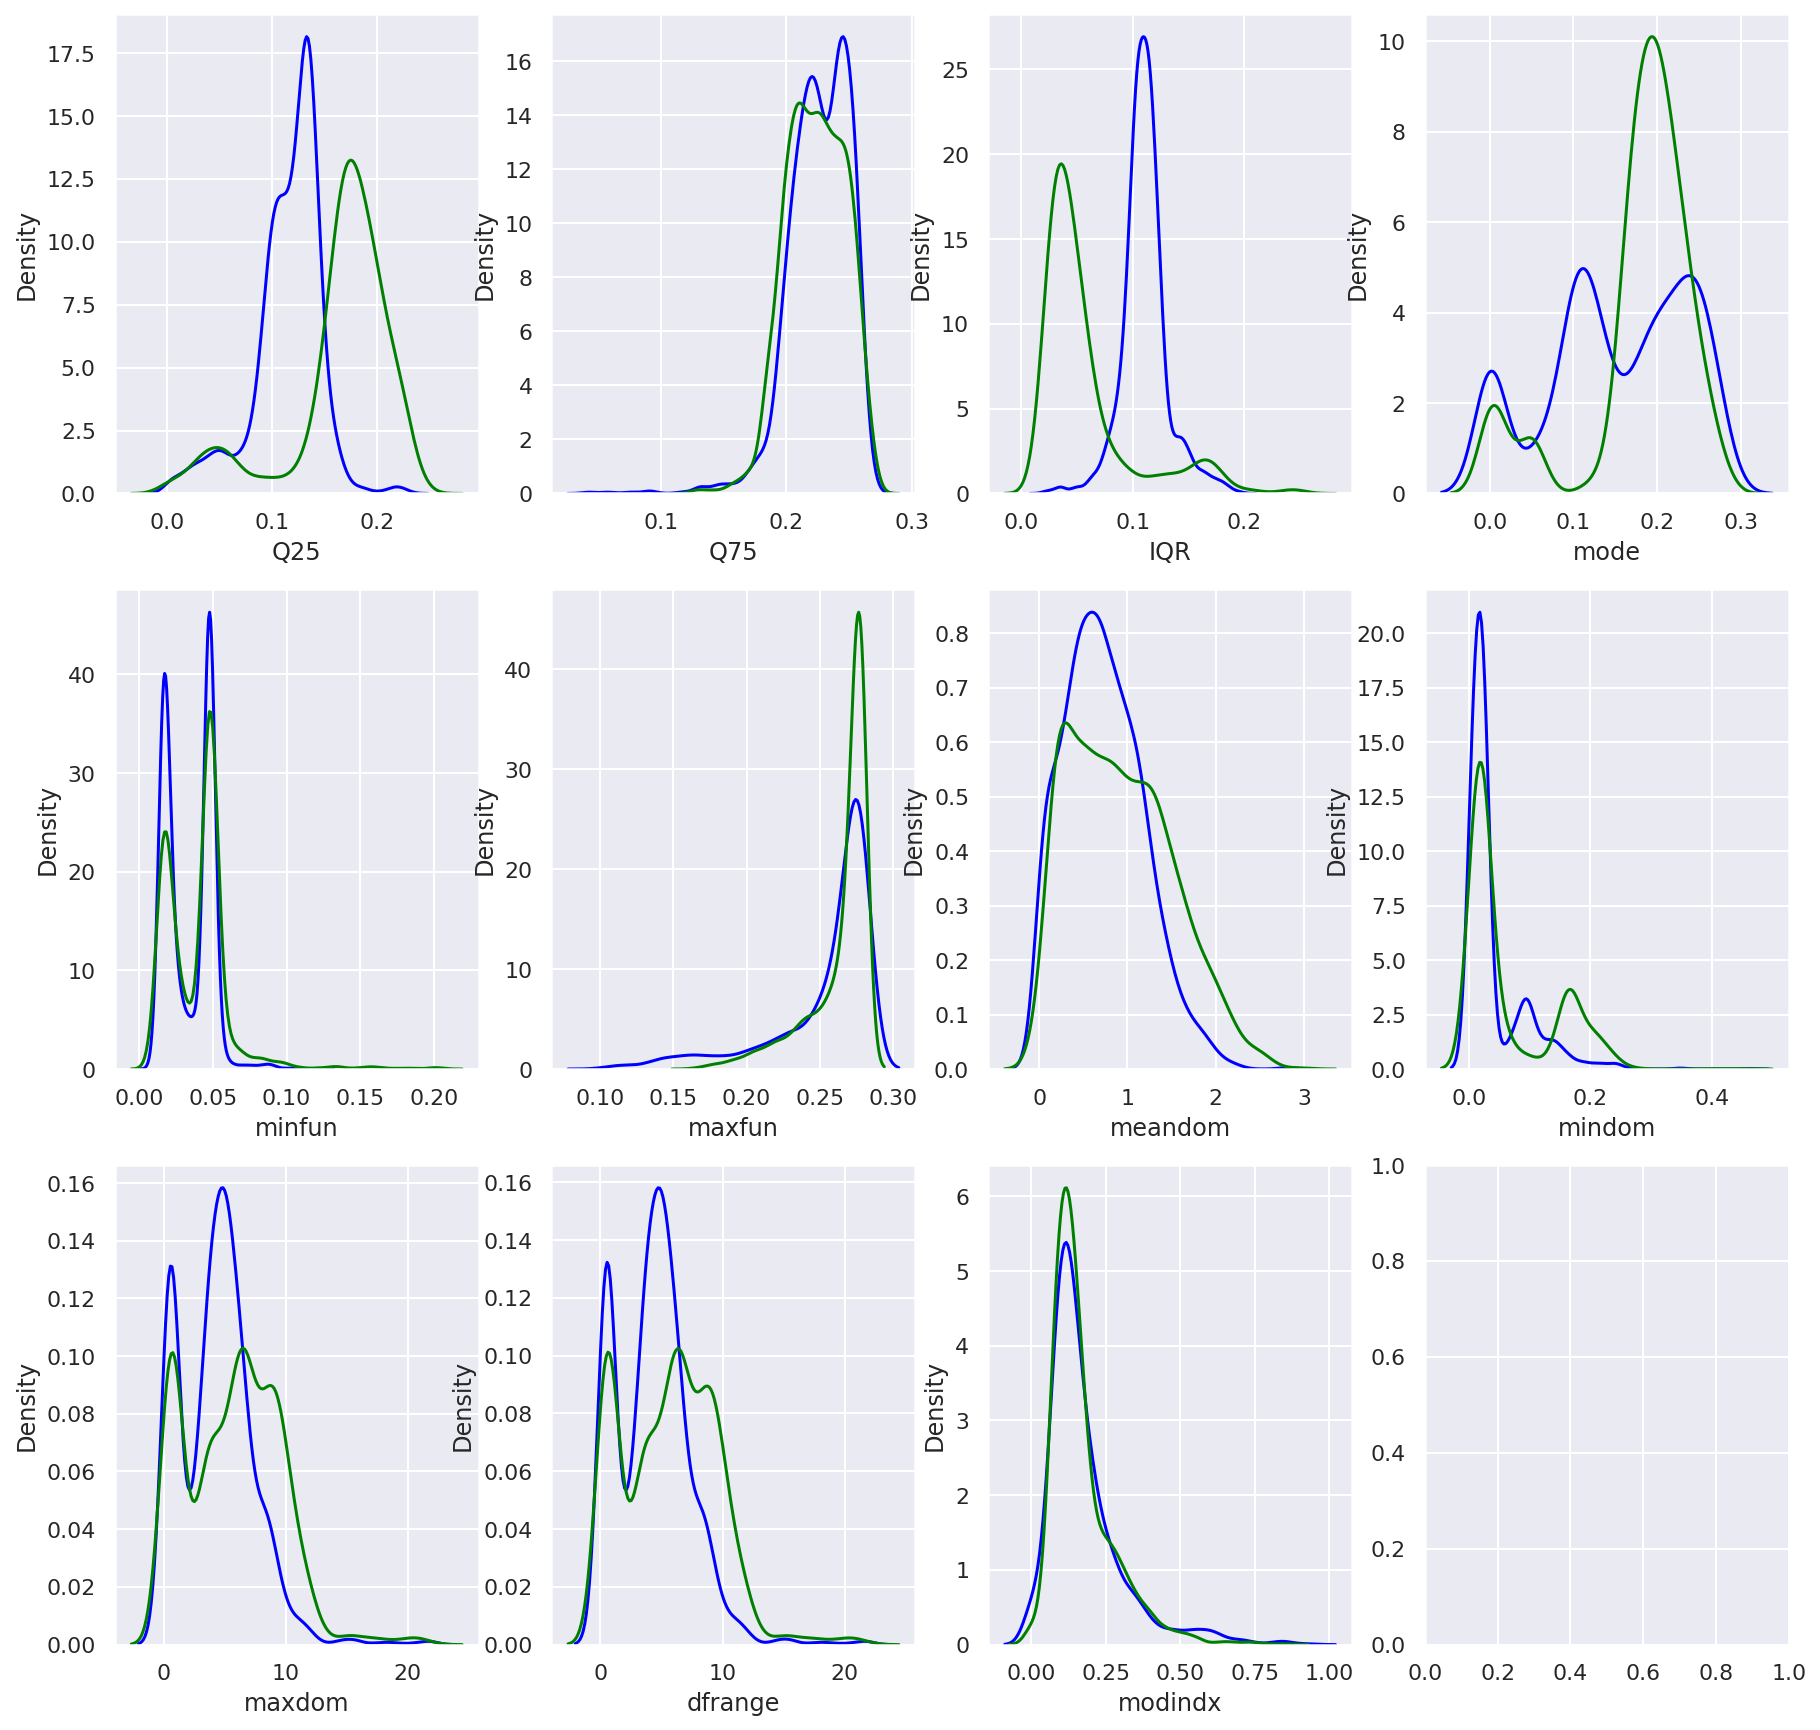

In [ ]:
plt.subplots(3, 4, figsize=(15, 15))

for i in range(1, 12):
    plt.subplot(3, 4, i)
    sns.kdeplot(df.loc[df['label'] == 'male', df.columns[i-1]], color='blue',
                label='Male')
    sns.kdeplot(df.loc[df['label'] == 'female', df.columns[i-1]],
                color='green', label='Female')

Some features seem to have big overlap between males, and females. Therefore I will drop those features from the dataframe.

In [ ]:
df.drop(labels=['Q75', 'minfun', 'maxfun', 'modindx'], axis=1, inplace=True)
df.head()

,Q25,IQR,mode,meandom,mindom,maxdom,dfrange,label
0,0.015071,0.075122,0.000000,0.007812,0.007812,0.007812,0.000000,male
1,0.019414,0.073252,0.000000,0.009014,0.007812,0.054688,0.046875,male
2,0.008701,0.123207,0.000000,0.007990,0.007812,0.015625,0.007812,male
3,0.096582,0.111374,0.083878,0.201497,0.007812,0.562500,0.554688,male
4,0.078720,0.127325,0.104261,0.712812,0.007812,5.484375,5.476562,male


## 3.3 Split data into training and testing set

In [ ]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [ ]:
from sklearn.model_selection import train_test_split
# use the random state for having reproducible results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=0)

## 3.4 Feature Scaling

In [ ]:
# value ranges before feature scaling
df.describe()

,Q25,IQR,mode,meandom,mindom,maxdom,dfrange
count,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000
mean,0.140456,0.084309,0.165282,0.829211,0.052647,5.047277,4.994630
std,0.048680,0.042783,0.077203,0.525205,0.063299,3.521157,3.520039
min,0.000229,0.014558,0.000000,0.007812,0.004883,0.007812,0.000000
25%,0.111087,0.042560,0.118016,0.419828,0.007812,2.070312,2.044922
50%,0.140286,0.094280,0.186599,0.765795,0.023438,4.992188,4.945312
75%,0.175939,0.114175,0.221104,1.177166,0.070312,7.007812,6.992188
max,0.247347,0.252225,0.280000,2.957682,0.458984,21.867188,21.843750


It would be better for the models to put values on the same scale by appling feature scaling to avoid the dominance of some features over others due to their higher scale although they could have less predictive power as a feature.

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# 4. Modeling (Trying different classifiers)

I will do this to understand more the different linear and non-linear classifiers.

In [ ]:
df['label'].value_counts()

female    1584
male      1584
Name: label, dtype: int64

> **Evaluation:** I will only use accuracy as my evaluation metric since precision, recall and F1-score are more useful in case of having unequal labels as far as I know, and the number of males and females in the dataset are exactly the same. Moreover, I think voice detection is not as critical as medical domains where precision and recall will be more important.

## 1. Linear Classifiers

### 1.1 Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0)
evaluate_model_fn(lr, X_train, y_train, X_test, y_test)

0.889589905362776

### 1.2 Support Vector Machine

In [ ]:
from sklearn.svm import SVC

svc = SVC(kernel='linear', random_state=0)
evaluate_model_fn(svc, X_train, y_train, X_test, y_test)

0.9037854889589906

## 2. Non-linear Classifiers

### 2.1 K-Nearest Neighbors (K-NN)

If K is too small it will be sensitive to noise, and if it is too high it may include majority points from other classes.

> Therefore a rule of thumb is to choose $K < \sqrt(n)$ where n is the number of training examples.

> Also choose K to be an odd number to avoid ties.

In [ ]:
np.sqrt(df.shape[0])

56.28498911788115

In [ ]:
def knn_optimize_fn(k, X_train, y_train, X_test, y_test):
    """Get the best number of nearest neighbors in KNN."""
    accuracies = []
    K = range(1, k)
    for i in K:
        # we will set metric='minkowski' with p=2 for choosing the euclidean
        # distance as written in the sklearn documentation 
        knn = KNeighborsClassifier(n_neighbors=i, metric='minkowski', p=2)
        accuracies.append(evaluate_model_fn(knn, X_train, y_train, X_test,
                                            y_test))
        
    plt.plot(K, accuracies, linestyle='dashed', marker='o',
             markerfacecolor='red')
    plt.xlabel('K')
    plt.ylabel('Accuracy')
    plt.show()
    print(f"Best K = {K[accuracies.index(max(accuracies))]}")


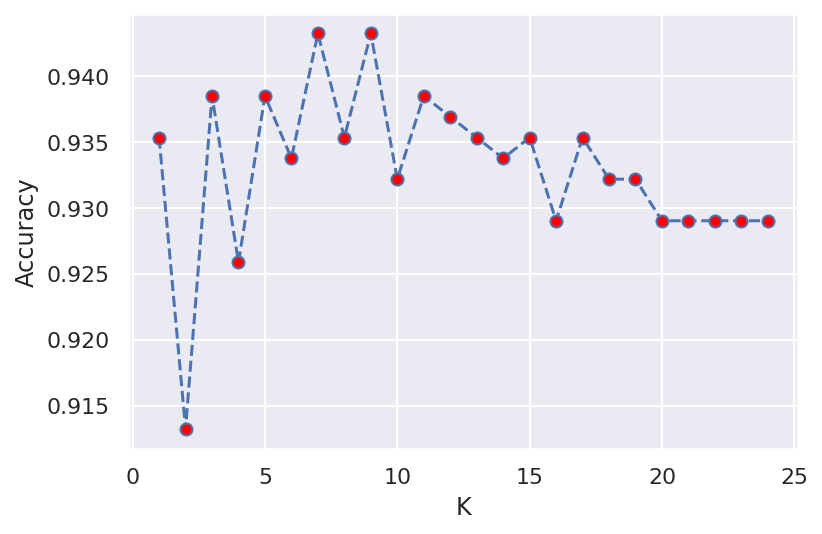

Best K = 7


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_optimize_fn(25, X_train, y_train, X_test, y_test)

In [ ]:
# we will set metric='minkowski' with p=2 for choosing the euclidean distance as
# written in the sklearn documentation 
knn = KNeighborsClassifier(n_neighbors=7, metric='minkowski', p=2)
evaluate_model_fn(knn, X_train, y_train, X_test, y_test)

0.943217665615142

### 2.2 Kernel Support Vector Machine (SVM)

In [ ]:
def svm_optimize_fn(X_train, y_train, X_test, y_test):
    """Get the best SVM kernel."""
    accuracies = []
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    for kernel in kernels:
        # we will set metric='minkowski' with p=2 for choosing the euclidean
        # distance as written in the sklearn documentation 
        svm = SVC(kernel = kernel, random_state = 0)
        accuracies.append(evaluate_model_fn(svm, X_train, y_train, X_test,
                                            y_test))
        
    plt.plot(kernels, accuracies, linestyle='dashed', marker='o',
             markerfacecolor='red')
    plt.xlabel('Kernel')
    plt.ylabel('Accuracy')
    plt.show()
    print(f"Best Kernel = {kernels[accuracies.index(max(accuracies))]}")


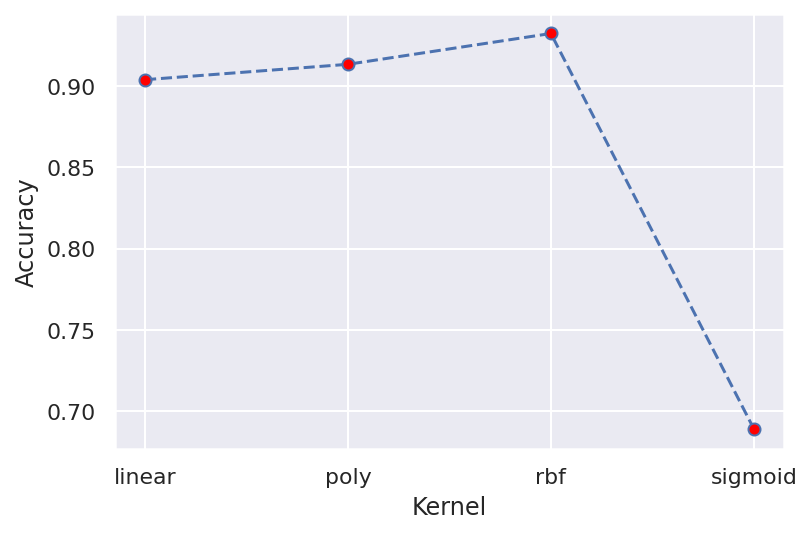

Best Kernel = rbf


In [ ]:
from sklearn.svm import SVC

svm_optimize_fn(X_train, y_train, X_test, y_test)

In [ ]:
svm = SVC(kernel = 'rbf', random_state = 0)
evaluate_model_fn(knn, X_train, y_train, X_test, y_test)

0.943217665615142

### 2.3 Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

nv = GaussianNB()
evaluate_model_fn(nv, X_train, y_train, X_test, y_test)

0.8832807570977917

### 2.4 Decision Tree (DT)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# using entropy criterion
dt = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
evaluate_model_fn(dt, X_train, y_train, X_test, y_test)

0.917981072555205

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# using gini criterion
dt = DecisionTreeClassifier(criterion = 'gini', random_state = 0)
evaluate_model_fn(dt, X_train, y_train, X_test, y_test)

0.9148264984227129

Therefore **entropy** is a better criterion in this case.

### 2.5 Random Forest (RD)

I was guided in here with this blog post [name](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74).

#### 2.5.1 Random Hyperparameter Grid

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# number of features to consider at every split
max_features = ['auto', 'sqrt']
# maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 150, num = 15)]
# minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# method of selecting samples for training each tree
bootstrap = [True, False]
# create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)               

{'bootstrap': [True, False],
 'max_depth': [10,
               20,
               30,
               40,
               50,
               60,
               70,
               80,
               90,
               100,
               110,
               120,
               130,
               140,
               150],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000]}


#### 2.5.2 Random Search Training

Use the random grid to search for best hyperparameters.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# create the base model to tune
rf = RandomForestClassifier()
# random search of parameters using 5 fold cross validation, 
# search across 200 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 200, cv = 5, verbose=2, random_state=0,
                               n_jobs = -1)
# fit the random search model
rf_random.fit(X_train, y_train)

pprint(rf_random.best_params_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 34.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 54.0min finished


{'bootstrap': False,
 'max_depth': 140,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 2000}


From these results, we should be able to narrow the range of values for each hyperparameter.

Now we could narrow the range of values for each hyperparameter using the **Random Search** results.

#### 2.5.3 Grid Search with Cross Validation

Using Random Search results we could do **GridSearchCV** which evaluates all the combinations that we define instead of random sampling. We should make another grid based on the best values we obtained by random search for using Grid Search.

In [114]:
from sklearn.model_selection import GridSearchCV

# create the parameter grid based on the random search results
param_grid = {
    'bootstrap': [False],
    'max_depth': [140, 150, 160, 170],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [1900, 2000, 2100]
}

# create a based model
rf = RandomForestClassifier()
# instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

# fit the grid search to the data
grid_search.fit(X_train, y_train)

pprint(grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 40.4min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 60.2min finished


{'bootstrap': False,
 'max_depth': 140,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 1900}


#### 2.5.4 Implement the RF Algorithm using the best obtained hyperparameters

The result of `rf = grid_search.best_estimator_` is
```
RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=140, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1900,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
```

In [ ]:
# rf = RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
#                        criterion='gini', max_depth=140, max_features='sqrt',
#                        max_leaf_nodes=None, max_samples=None,
#                        min_impurity_decrease=0.0, min_impurity_split=None,
#                        min_samples_leaf=1, min_samples_split=10,
#                        min_weight_fraction_leaf=0.0, n_estimators=1900,
#                        n_jobs=None, oob_score=False, random_state=None,
#                        verbose=0, warm_start=False)

In [116]:
rf = grid_search.best_estimator_
evaluate_model_fn(rf, X_train, y_train, X_test, y_test)

0.9479495268138801

So unitl now **Random Forest** final obtained model using grid search has obtained the highest accuracy on the test set with `accuracy = 0.9479495268138801`.

# 5. Optimization (Feature Selection)

Now that we have nearly obtained the best models given the features we have now, why not see if these features were the best or not by reselecting features based on their performance on these newly obtained models.

So now instead of feature engineering then modeling, I will somehow inverse the process. Therefore, based on having some models, I will:
1. Get the predictive power of each feature independently by using it alone across all models and see which feature will give the highest accuracy with the best model.
2. Based on their predictive power, I will select features that obtained certain accuracies.
3. Using these features, I will get the best model which resulted in the highest accuracy.
4. Then I will return back to step 2 by decreasing the accuracy threshold a little bit, and therefore adding more features to the model, and moving until step 3 to get the model with highest accuracy.
5. Repeat the above process and see which model has overall obtained the highest accuracy and choose this model as your final model.

## 5.1 Get Each Feature Predictive Power

We could check the predictive power on using them only by using the `columns_predictive_power_fn` function defined above in the helpers functions.

In [125]:
columns_predictive_power_fn('voice.csv')

Using meanfreq column
Best classifier is Kernel SVM with accuracy 0.673.

Using sd column
Best classifier is Naive Bayes with accuracy 0.833.

Using median column
Best classifier is Support Vector Machine with accuracy 0.649.

Using Q25 column
Best classifier is Support Vector Machine with accuracy 0.884.

Using Q75 column
Best classifier is Kernel SVM with accuracy 0.543.

Using IQR column
Best classifier is Kernel SVM with accuracy 0.928.

Using skew column
Best classifier is Kernel SVM with accuracy 0.665.

Using kurt column
Best classifier is KNN with accuracy 0.574.

Using sp.ent column
Best classifier is Kernel SVM with accuracy 0.784.

Using sfm column
Best classifier is Kernel SVM with accuracy 0.745.

Using mode column
Best classifier is Kernel SVM with accuracy 0.713.

Using centroid column
Best classifier is Kernel SVM with accuracy 0.673.

Using meanfun column
Best classifier is Naive Bayes with accuracy 0.957.

Using minfun column
Best classifier is Naive Bayes with accura

In [130]:
def choose_best_model_given_df_fn(dataframe):
    """Extract features and labels, split data into training and testing sets,
    perforem feature scaling and finally fit the best model."""
    print(f'New Data Shape: {dataframe.shape}')

    X = dataframe.iloc[:, :-1].values
    y = dataframe.iloc[:, -1].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                        random_state=0)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    choose_best_model_fn(X_train, y_train, X_test, y_test)

## 5.2 Using Features with Accuracy above 90%

In [131]:
df = pd.read_csv('voice.csv')
df = df[['IQR', 'meanfun', 'label']]
choose_best_model_given_df_fn(df)

New Data Shape: (3168, 3)
Best classifier is Kernel SVM with accuracy 0.973.


## 5.3 Using Features with Accuracy above 80%

In [132]:
df = pd.read_csv('voice.csv')
df = df[['IQR', 'meanfun', 'sd', 'Q25', 'label']]
choose_best_model_given_df_fn(df)

New Data Shape: (3168, 5)
Best classifier is KNN with accuracy 0.984.


## 5.4 Using Features with Accuracy above 70%

In [133]:
df = pd.read_csv('voice.csv')
df = df[['IQR', 'meanfun', 'sd', 'Q25', 'sp.ent', 'sfm', 'mode', 'label']]
choose_best_model_given_df_fn(df)

New Data Shape: (3168, 8)
Best classifier is Kernel SVM with accuracy 0.985.


## 5.5 Using Features with Accuracy above 60%

In [134]:
df = pd.read_csv('voice.csv')
df = df[['IQR', 'meanfun', 'sd', 'Q25', 'sp.ent', 'sfm', 'mode', 'meanfreq',
         'median', 'skew', 'centroid', 'meandom', 'mindom', 'maxdom', 'dfrange',
         'label']]
choose_best_model_given_df_fn(df)

New Data Shape: (3168, 16)
Best classifier is Kernel SVM with accuracy 0.984.


## 5.5 Using all features

In [135]:
df = pd.read_csv('voice.csv')
choose_best_model_given_df_fn(df)

New Data Shape: (3168, 21)
Best classifier is Kernel SVM with accuracy 0.985.


# 6. Conclusion

By using the final optimization technique we obtained models with higher accuracies than using the features obtained from the first Exploratory Data Analysis (EDA) which got us an accuracy of 0.94 by using **Random Search** then **Grid Search** in **Random Forest**. Now, after optimization the best models are:
1. Using all features: **RBF Kernel SVM** with accuracy 0.985.
2. Using these features: `['IQR', 'meanfun', 'sd', 'Q25', 'sp.ent', 'sfm', 'mode', 'label']` **RBF Kernel SVM** with accuracy 0.985.

So I would prefer to go with the second option to avoid including unnecessary features which will need more computations since both obtained the same accuracy to the third decimal place but the second option has less features with higher predictive power if when they were acting in the models independently.